# <span style='font-family:"Times New Roman"'> <span styel=''> Image Classification

## <span style='font-family:"Times New Roman"'> <span styel=''> Loading Required Modules:

In [1]:
from sklearn.preprocessing import OneHotEncoder
from skimage.color import rgb2gray
from skimage.draw import polygon
import matplotlib.pyplot as plt 
from skimage import morphology
from skimage import feature
from numpy import argmax
from sklearn import svm
import scipy.io as spio 
from numpy import array
import skimage.measure
import sklearn.metrics
from PIL import Image
import scipy as sp
import numpy as np
import imageio
import math
import glob
import time
import sys
import cv2
import os

%matplotlib inline

In [2]:
plt.rcParams["font.family"] = "Times New Roman"  #Setting Global Font to Times New Roman

In [3]:
#Setting Global Path of Notebook to Avoid Hard-coding
notenookpath = os.path.abspath('') 
os.chdir(notenookpath)

# <span style='font-family:"Times New Roman"'> <span styel=''>(a) CalTech101 Dataset setup.

#### <span style='font-family:"Times New Roman"'> <span styel=''>In this project, we will use the CalTech101 dataset, which is a standard dataset used for image classification. You can find important information about this dataset at (http://www.vision.caltech.edu/Image_Datasets/Caltech101/). From that webpage, download the dataset itself (http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) which is some 126 MB and also the annotations (http://www.vision.caltech.edu/Image_Datasets/Caltech101/Annotations.tar) which is some 13 MB and which will allow us to focus our feature extraction on only the objects in the images. Extract the image dataset and the annotations in your working directory.

## <span style='font-family:"Times New Roman"'> <span styel=''>(a-i) Display example CalTech101 images:

In [4]:
#Saving name of categories inside a list so we can loop over them:
categories_directory = sorted(glob.glob('101_ObjectCategories/*'))

#### <span style='font-family:"Times New Roman"'> <span styel=''>Displaying first images from each category (image_0001.jpg): 

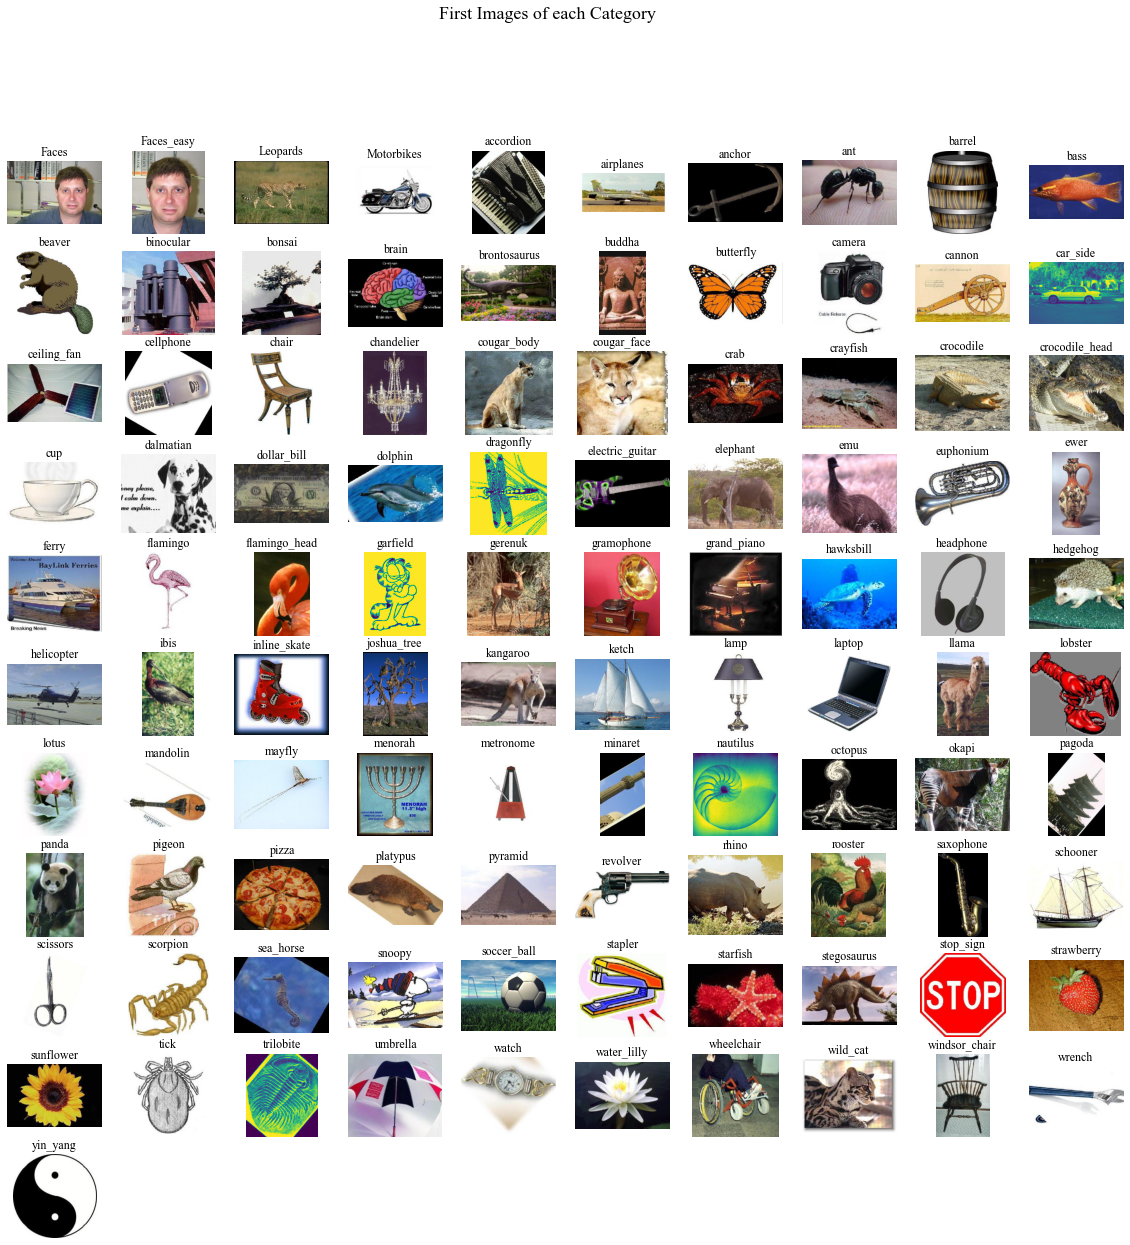

In [5]:
#Defining number of rows and columns:
nrows, ncols = 11 , 10
#Seting figure size:
plt.figure(figsize=(20,20))
#looping over 101 categories 
for i in range (len(categories_directory)):
    plt.subplot(nrows, ncols, i+1)
    #Reading Images as a numpy array 
    im = plt.imread(categories_directory[i] + '\\image_0001.jpg')
    #Displaying numpy arrays 
    plt.imshow(im)
    #Setting each category name as title for each image 
    plt.title(categories_directory[i][21:])
    plt.axis('off')
plt.suptitle('First Images of each Category', fontsize = 18)
plt.show()

## <span style='font-family:"Times New Roman"'> <span styel=''>(a-ii) Reading and visualizing annotations:

#### <span style='font-family:"Times New Roman"'> <span styel=''>This returns a dictionary with variable names as keys.

#### <span style='font-family:"Times New Roman"'> <span styel=''>Reading the image 101_ObjectCategories/emu/image_0001.jpg and displaying it while Ploting the annotation outline on top of it.

In [6]:
#Reading annotaion for first image in emu category 
ann = spio.loadmat('Annotations\\emu\\annotation_0001.mat')

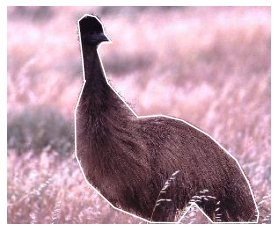

In [7]:
#Reading Images as a numpy array 
im = plt.imread('101_ObjectCategories\\emu\\image_0001.jpg')
#Displaying numpy arrays 
plt.imshow(im)
#Plotting annotation overlayed on real image
plt.plot(ann['obj_contour'][0,:]+ann['box_coord'][0,2]-1,ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,'w')
plt.axis('off')
plt.show()

## <span style='font-family:"Times New Roman"'> <span styel=''>(a-iii) Generating an object mask:

#### <span style='font-family:"Times New Roman"'> <span styel=''> Using the object contour outline to define a binary mask images:

In [8]:
#Saving name of annotations inside a list so we can loop over them:
annotations_directory = sorted(glob.glob('Annotations/*'))

#### <span style='font-family:"Times New Roman"'> <span styel=''>looping over categories, loading the first annotation (annotation_0001.mat) from each of the 101 categories, using the corresponding obj_contour to define an object mask, and displaying masks in one location of an 11×10 subplot.

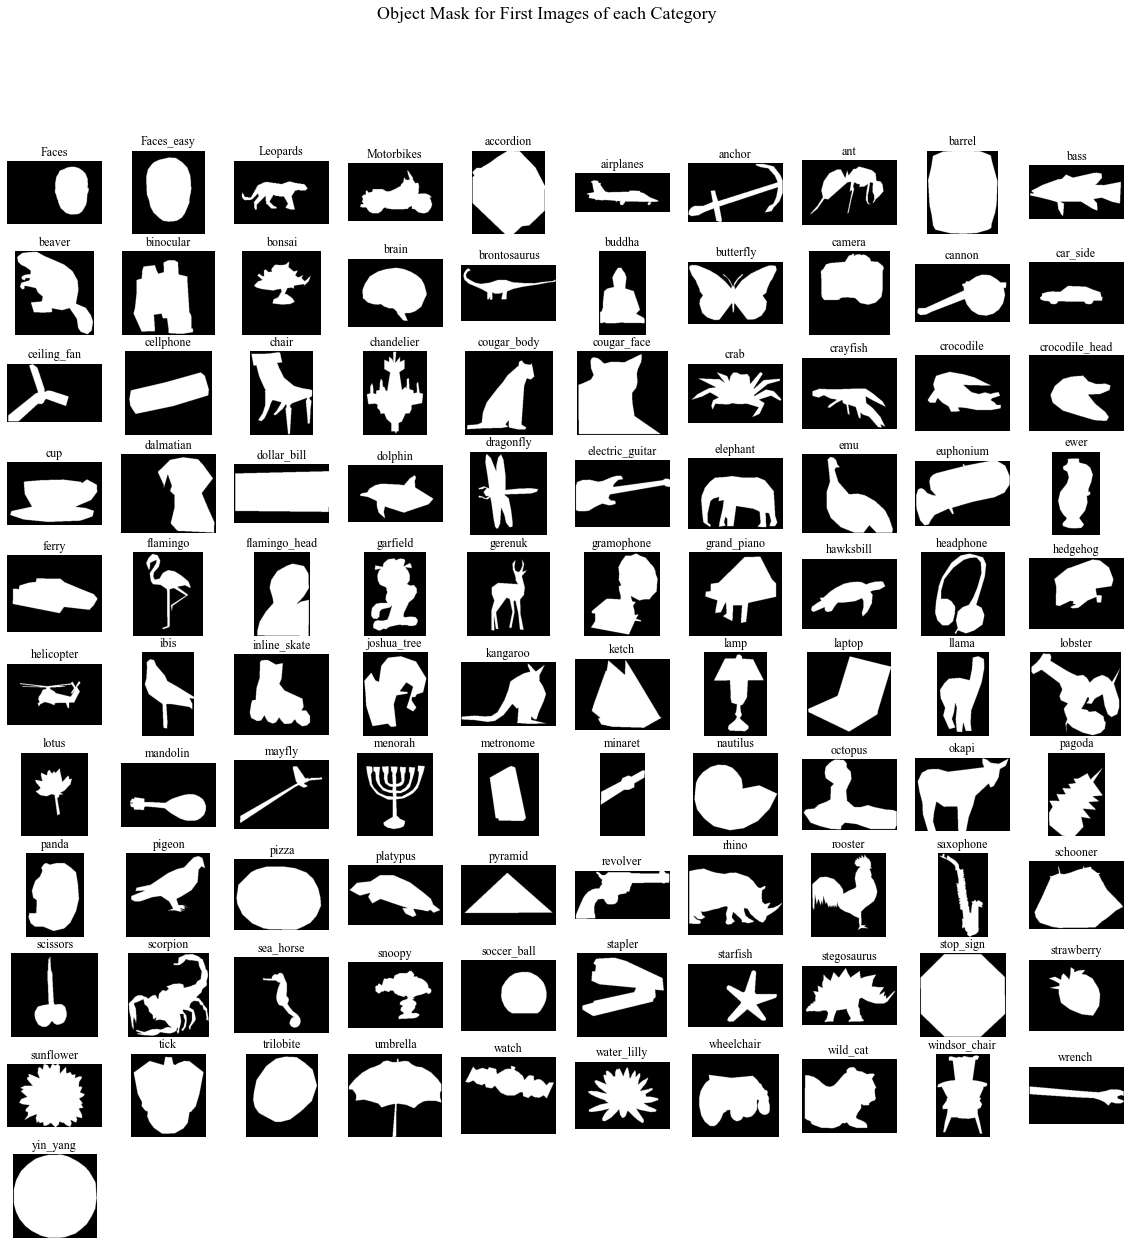

In [9]:
#Defining number of rows and columns:
nrows, ncols = 11 , 10
#Seting figure size:
plt.figure(figsize=(20,20))
#looping over 101 categories 
for i in range (len(categories_directory)):
    im = plt.imread(categories_directory[i] + '\\image_0001.jpg')
    plt.subplot(nrows, ncols, i+1)
    #Reading annotation file 
    ann = spio.loadmat(annotations_directory[i] + '\\annotation_0001.mat')
    
    r,c = polygon(ann['obj_contour'][1,:]+ann['box_coord'][0,0]-1,ann['obj_contour'][0,:]+\
                  ann['box_coord'][0,2]-1,(im.shape[0],im.shape[1]))
    # Making binary mask from annotation file 
    A=np.zeros((im.shape[0],im.shape[1]))
    A[r,c]=1
    #isplayinfg Mask
    plt.imshow(A, cmap = 'gray')
    plt.title(categories_directory[i][21:])
    plt.axis('off')
plt.suptitle('Object Mask for First Images of each Category', fontsize = 18)
plt.show()

# <span style='font-family:"Times New Roman"'> <span styel=''>(b) Extracting Color Features.

#### <span style='font-family:"Times New Roman"'> <span styel=''> In section (b) a function for color features extraction from images is generated.

## <span style='font-family:"Times New Roman"'> <span styel=''>(b-i) Color feature function:

In [138]:
def extract_color_features(im, mask):
    #This simple functions reads image and its mask and returns 
    #mean, standard deviation, median, minimum, and maximum value 
    #for masked region for RGB and HSV channels.
    
    #both im and mask are file names in the respective directory 
    
    image = plt.imread(im)
    
    if(len(image.shape)<3):
        image = skimage.color.gray2rgb(image)
    
    
    annot = spio.loadmat(mask)
    r,c = polygon(annot['obj_contour'][1,:]+annot['box_coord'][0,0]-1,annot['obj_contour'][0,:]+\
                  annot['box_coord'][0,2]-1,(image.shape[0],image.shape[1]))
    # Making binary mask from annotation file 
    GM=np.zeros((image.shape[0],image.shape[1]))
    GM[r,c]=1
    
    #mean value (R channel) in masked region
    R_mean = np.mean(image[:,:,0][GM == 1])
    #std value (R channel) in masked region
    R_std = np.std(image[:,:,0][GM == 1])
    #median value (R channel) in masked region
    R_median = np.median(image[:,:,0][GM == 1])
    #min value (R channel) in masked region
    R_min = np.min(image[:,:,0][GM == 1])
    #max value (R channel) in masked region
    R_max = np.max(image[:,:,0][GM == 1])
    #mean value (G channel) in masked region
    G_mean = np.mean(image[:,:,1][GM == 1])
    #std value (G channel) in masked region
    G_std = np.std(image[:,:,1][GM == 1])
    #median value (G channel) in masked region
    G_median = np.median(image[:,:,1][GM == 1])
    #min value (G channel) in masked region
    G_min = np.min(image[:,:,1][GM == 1])
    #max value (G channel) in masked region
    G_max = np.max(image[:,:,1][GM == 1])
    #mean value (B channel) in masked region
    B_mean = np.mean(image[:,:,2][GM == 1])
    #std value (B channel) in masked region
    B_std = np.std(image[:,:,2][GM == 1])
    #median value (B channel) in masked region
    B_median = np.median(image[:,:,2][GM == 1])
    #min value (B channel) in masked region
    B_min = np.min(image[:,:,2][GM == 1])
    #max value (B channel) in masked region
    B_max = np.max(image[:,:,2][GM == 1])
    #Converting RGB to HSV
    imhsv = skimage.color.rgb2hsv(image)
    #mean value (H channel) in masked region
    H_mean = np.mean(imhsv[:,:,0][GM == 1])
    #std value (H channel) in masked region
    H_std = np.std(imhsv[:,:,0][GM == 1])
    #median value (H channel) in masked region
    H_median = np.median(imhsv[:,:,0][GM == 1])
    #min value (H channel) in masked region
    H_min = np.min(imhsv[:,:,0][GM == 1])
    #max value (H channel) in masked region
    H_max = np.max(imhsv[:,:,0][GM == 1])
    #mean value (S channel) in masked region
    S_mean = np.mean(imhsv[:,:,1][GM == 1])
    #std value (S channel) in masked region
    S_std = np.std(imhsv[:,:,1][GM == 1])
    #median value (S channel) in masked region
    S_median = np.median(imhsv[:,:,1][GM == 1])
    #min value (S channel) in masked region
    S_min = np.min(imhsv[:,:,1][GM == 1])
    #max value (S channel) in masked region
    S_max = np.max(imhsv[:,:,1][GM == 1])
    #mean value (V channel) in masked region
    V_mean = np.mean(imhsv[:,:,2][GM == 1])
    #std value (V channel) in masked region
    V_std = np.std(imhsv[:,:,2][GM == 1])
    #median value (V channel) in masked region
    V_median = np.median(imhsv[:,:,2][GM == 1])
    #min value (V channel) in masked region
    V_min = np.min(imhsv[:,:,2][GM == 1])
    #max value (V channel) in masked region
    V_max = np.max(imhsv[:,:,2][GM == 1])
    
    
    ColorFeatures = [R_mean, R_std, R_median, R_min, R_max, G_mean, G_std, G_median, \
         G_min, G_max, B_mean, B_std, B_median, B_min, B_max,\
         H_mean, H_std, H_median, H_min, H_max, S_mean, S_std, S_median, \
         S_min, S_max, V_mean, V_std, V_median, V_min, V_max]
    
    
    
    ColorFeaturesNames = ["R_mean", "R_std", "R_median", "R_min", "R_max", "G_mean", "G_std", "G_median", \
     "G_min", "G_max", "B_mean", "B_std", "B_median", "B_min", "B_max",\
     "H_mean", "H_std", "H_median", "H_min", "H_max", "S_mean", "S_std", "S_median", \
     "S_min", "S_max", "V_mean", "V_std", "V_median", "V_min", "V_max"]
    
    
    
    return ColorFeatures, ColorFeaturesNames

## <span style='font-family:"Times New Roman"'> <span styel=''>(b-ii) Example color features:

#### <span style='font-family:"Times New Roman"'> <span styel=''> Extracting color features from 101_ObjectCategories/emu/image_0001.jpg:

In [11]:
emuimagedirectory = '101_ObjectCategories\\emu\\image_0001.jpg'
emuannotationdirectory = 'Annotations\\emu\\annotation_0001.mat'
f,fnames=extract_color_features(emuimagedirectory,emuannotationdirectory)

In [12]:
print('Extracted color feature values are: ')
print(f)

Extracted color feature values are: 
[89.66263904034896, 41.77544730860127, 85.0, 3, 255, 60.43520174482006, 36.479201879692546, 53.0, 0, 250, 70.16239912758996, 37.50792712320316, 63.0, 0, 255, 0.9319160505364285, 0.07237925220295986, 0.9473684210526316, 0.0, 0.9966666666666667, 0.3612537870160193, 0.11130164163464257, 0.34951456310679613, 0.019607843137254943, 1.0, 0.35243261273975235, 0.16304442276782372, 0.3333333333333333, 0.0196078431372549, 1.0]


In [13]:
print('Extracted color feature names are: ')
print(fnames)

Extracted color feature names are: 
['R_mean', 'R_std', 'R_median', 'R_min', 'R_max', 'G_mean', 'G_std', 'G_median', 'G_min', 'G_max', 'B_mean', 'B_std', 'B_median', 'B_min', 'B_max', 'H_mean', 'H_std', 'H_median', 'H_min', 'H_max', 'S_mean', 'S_std', 'S_median', 'S_min', 'S_max', 'V_mean', 'V_std', 'V_median', 'V_min', 'V_max']


# <span style='font-family:"Times New Roman"'> <span styel=''>(c) Extracting Boundary Features.

#### <span style='font-family:"Times New Roman"'> <span styel=''> In section (c) a function for boundary features extraction from images is generated.

## <span style='font-family:"Times New Roman"'> <span styel=''>(c-i) Boundary feature function:

In [136]:
def gen_mask(imdir, maskdir):
    
    image = plt.imread(imdir)
    
    
    annot = spio.loadmat(maskdir)
    r,c = polygon(annot['obj_contour'][1,:]+annot['box_coord'][0,0]-1,annot['obj_contour'][0,:]+\
                  annot['box_coord'][0,2]-1,(image.shape[0],image.shape[1]))
    
    # Making binary mask from annotation file 
    GM=np.zeros((image.shape[0],image.shape[1]))
    GM[r,c]=1
    GM = GM.astype(bool)
    GM = morphology.remove_small_holes(GM)
    GM = GM * 1 
    
    return GM

In [15]:
def extract_boundary_features(mask):
    
    #Finding boundary x and y location
    B=skimage.measure.find_contours(mask,0.5)
    #Dropping Last element of B
    B = B[0][:-1]
    #Transforming y values to imaginary numbers 
    s_k = [B[:,0],B[:,1]*1j] #Complex Signal
    
    #Taking a length-10,000 FFT of complex signal
    S = np.fft.fft(s_k, n = 10000)
    
    #Bin the length-10,000 Fourier descriptor S into a length-
    #10 Fourier descriptor vector f:
    
    fd = np.zeros(10)
    for k in range(0,10):
        fd[k] = np.abs(S[:,k*1000:(k+1)*1000].sum())
    
    #Features' name 
    FourierDescriptors = ['Fourier_desc_a0', 'Fourier_desc_a1', 'Fourier_desc_a2', 'Fourier_desc_a3', \
                          'Fourier_desc_a4', 'Fourier_desc_a5', 'Fourier_desc_a6', 'Fourier_desc_a7', \
                          'Fourier_desc_a8', 'Fourier_desc_a9']
    
    return fd, FourierDescriptors

## <span style='font-family:"Times New Roman"'> <span styel=''>(c-ii) Example boundary features:

#### <span style='font-family:"Times New Roman"'> <span styel=''> Extracting boundary features from 101_ObjectCategories/emu/image_0001.jpg:

In [16]:
#Reading Image Directory
emuimagedirectory = '101_ObjectCategories\\emu\\image_0001.jpg'
#Reading Annotation Directory
emuannotationdirectory = 'Annotations\\emu\\annotation_0001.mat'
#Generating mask using function
emumask = gen_mask(emuimagedirectory, emuannotationdirectory)
#Extracting boundary features:
f,fnames=extract_boundary_features(emumask)

In [17]:
print('Extracted frequency feature values are: ')
print(f)

Extracted frequency feature values are: 
[3637364.51489201  428533.91905037  268666.33382016  211784.36752886
  190387.59983921  190366.9532755   211709.16826401  269000.4876408
  430190.94765179 3695814.06216116]


In [18]:
print('Extracted frequency feature names are: ')
print(fnames)

Extracted frequency feature names are: 
['Fourier_desc_a0', 'Fourier_desc_a1', 'Fourier_desc_a2', 'Fourier_desc_a3', 'Fourier_desc_a4', 'Fourier_desc_a5', 'Fourier_desc_a6', 'Fourier_desc_a7', 'Fourier_desc_a8', 'Fourier_desc_a9']


# <span style='font-family:"Times New Roman"'> <span styel=''>(d) Extracting Region features.

#### <span style='font-family:"Times New Roman"'> <span styel=''> In section (d) a function for region features extraction from images is generated.

## <span style='font-family:"Times New Roman"'> <span styel=''>(d-i) Hu moments function:

In [19]:
def moment_calc(Img,p,q):
    #Generating zero array with size of the image:
    twod_moment = np.zeros((Img.shape))
    #Looping over rows of image
    for r in range (Img.shape[0]):
        #Looping over columns of image
        for c in range (Img.shape[1]):
            #Calculating 2D moment:
            h = (r**p)*(c**q)*Img[r,c]
            #Storing moment inside the zero array matrix:
            twod_moment[r,c] = h
    #Returning 2D moment as a value (sum of all moments)
    return (np.sum(twod_moment))

In [20]:
def central_moment_calc(Img,p,q,xbar,ybar):
    #Generating zero array with size of the image:
    central_moment = np.zeros((Img.shape))
    #Looping over rows of image
    for r in range (Img.shape[0]):
        #Looping over columns of image
        for c in range (Img.shape[1]):
            #Calculating 2D central moment:
            h = ((r-xbar)**p)*((c-ybar)**q)*Img[r,c]
            central_moment[r,c] = h
    #Returning 2D central moment as a value (sum of all moments)
    return (np.sum(central_moment))

In [21]:
 def extract_hu_moments(mask):
        
    #The following function extracts hu moments based on provided 
    #equations (12-34) through(12-45) in the Gonzalez book [1].)
    #[1] Gonzalez, Rafael C., Richard Eugene Woods, and Steven L. Eddins. Digital 
    #image processing using MATLAB. Pearson Education India, 2004.
        
    M_00 = np.sum(mask)
    
    M_10 = moment_calc(mask,1,0)
    
    M_01 = moment_calc(mask,0,1)
    
    nu_20 = central_moment_calc(mask,2,0,M_10/M_00,M_01/M_00)/(M_00**2)
    
    nu_02 = central_moment_calc(mask,0,2,M_10/M_00,M_01/M_00)/(M_00**2)
    
    nu_11 = central_moment_calc(mask, 1, 1, M_10/M_00, M_01/M_00) / (M_00**2)
    
    nu_30 = central_moment_calc(mask, 3, 0, M_10/M_00, M_01/M_00) / (M_00**2.5)
    
    nu_03 = central_moment_calc(mask, 0, 3, M_10/M_00, M_01/M_00) / (M_00**2.5)
    
    nu_12 = central_moment_calc(mask, 1, 2, M_10/M_00, M_01/M_00) / (M_00**2.5)
    
    nu_21 = central_moment_calc(mask, 2, 1, M_10/M_00, M_01/M_00) / (M_00**2.5)
    
    # Eq. (12-39)
    phi_1 =  nu_20 + nu_02
    # Eq. (12-40)
    phi_2 =  ((nu_20 - nu_02) ** 2) + (4*(nu_11**2))
    # Eq. (12-41)
    phi_3 = (nu_30 - 3 * nu_12) ** 2 + (3 * nu_21 - nu_03) ** 2
    # Eq. (12-42)
    phi_4 = (nu_30 + nu_12) ** 2 + (nu_21 + nu_03) ** 2
    # Eq. (12-43)
    phi_5 = (nu_30 - 3 * nu_12) * (nu_30 + nu_12) * ((nu_30 + nu_12)**2 - 3 * (nu_21 + nu_03)**2)\
    + (3 * nu_21 - nu_03) * (nu_21 + nu_03) * (3 * (nu_30 + nu_12) ** 2 - (nu_21 + nu_03)**2)
    # Eq. (12-44)
    phi_6 = (nu_20 - nu_02) * ((nu_30 + nu_12) ** 2 - (nu_21 + nu_03) ** 2) +\
    4 * nu_11 * (nu_30 + nu_12) * (nu_21 + nu_03)
    # Eq. (12-45)
    phi_7 = (3 * nu_21 - nu_03) * (nu_30 + nu_12) * ((nu_30 + nu_12)**2 - 3 * (nu_21 + nu_03)**2) +\
    (3 * nu_12 - nu_30) * (nu_21 + nu_03) * (3 * (nu_30 + nu_12) ** 2 - (nu_21 + nu_03) ** 2)
    
    f = [phi_1, phi_2, phi_3, phi_4, phi_5, phi_6, phi_7]
    
    fnames = ['phi_1', 'phi_2', 'phi_3', 'phi_4', 'phi_5', 'phi_6', 'phi_7']
    
    
    return(f, fnames)

## <span style='font-family:"Times New Roman"'> <span styel=''>(d-ii) Example Hu moments:

#### <span style='font-family:"Times New Roman"'> <span styel=''> Extracting Hu moments from 101_ObjectCategories/emu/image_0001.jpg:

In [22]:
hu_moments, fnames = extract_hu_moments(emumask)

In [23]:
print('Extracted hu moments are: ')
print(hu_moments)

Extracted hu moments are: 
[0.2510941623851788, 0.022047385733876795, 0.006437407831751308, 0.0012677765412814875, 2.5454808522395282e-06, 1.2565845541501967e-05, 2.576367086492271e-06]


In [24]:
print('Extracted hu moments names are: ')
print(fnames)

Extracted hu moments names are: 
['phi_1', 'phi_2', 'phi_3', 'phi_4', 'phi_5', 'phi_6', 'phi_7']


## <span style='font-family:"Times New Roman"'> <span styel=''>(d-iii) Region feature extraction:

In [25]:
def RFE(mask):
    
    #This function extracts Region features using 
    #skimage.measure.regionprops toolbox.
    #This function returns list of Region Properties.
    #We are intrested in area, convex_area, eccentricity, equivalent_diameter, euler_number, extent,
    #filled_area, major_axis_length, minor_axis_length, perimeter, and solidity.
    
    features = skimage.measure.regionprops(mask.astype(int))
    
    area =  features[0].area
    
    convex_area = features[0].convex_area
    
    eccentricity = features[0].eccentricity
    
    equivalent_diameter = features[0].equivalent_diameter
    
    euler_number = features[0].euler_number
    
    extent = features[0].extent
    
    filled_area = features[0].filled_area
    
    major_axis_length = features[0].major_axis_length
    
    minor_axis_length = features[0].minor_axis_length
    
    perimeter = features[0].perimeter
    
    solidity = features[0].solidity
    
    f = [area, convex_area, eccentricity, equivalent_diameter, euler_number, extent, \
         filled_area, major_axis_length, minor_axis_length, perimeter, solidity]
    
    fnames = ['area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', \
         'filled_area', 'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']
    
    return(f, fnames)

## <span style='font-family:"Times New Roman"'> <span styel=''>(d-iv) Example region features:

#### <span style='font-family:"Times New Roman"'> <span styel=''> Extracting region features from 101_ObjectCategories/emu/image_0001.jpg:

In [26]:
EF , EFnames = RFE(emumask)

In [27]:
print('Extracted Region features are: ')
print(EF)

Extracted Region features are: 
[22925, 28789, 0.8620919826231704, 170.8479340321492, 1, 0.46087813115676896, 22925, 270.7075275837515, 137.18153400649797, 824.5655839020935, 0.7963110910417173]


In [28]:
print('Extracted Region features' 'names are: ')
print(EFnames)

Extracted Region featuresnames are: 
['area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']


# <span style='font-family:"Times New Roman"'> <span styel=''>(e) Extracting Texture Features.

#### <span style='font-family:"Times New Roman"'> <span styel=''> In section (e) a function for texture features extraction from images is generated.

## <span style='font-family:"Times New Roman"'> <span styel=''>(e-i) Texture features function:

In [29]:
def extract_texture_features(im,mask):
    
    #Following function will extract texture features 
    #from targeted image
    
    #Reading the image 
    image = plt.imread(im)
    
    #Following condition checks image and  
    #converts it to RGB if it is a grayscale image
    if(len(image.shape)<3):
        image = skimage.color.gray2rgb(image)
        
    #Converting RGB image to grayscale image
    image = skimage.color.rgb2gray(image)
    
    #Quantizing image to 32 levels
    I_q = np.round(image*31).astype(int)
    
    #Setting all pixels outside of the mask to 32
    I_q[mask == 0] = 32
        
    #compute the gray-level co-occurrence matrix (GLCM) for the set of orientations
    #θ=[0,45,90,135] degrees and distances d=[1,2,3,4] pixels.
    GLCM = feature.greycomatrix(I_q,distances=(1,2,3,4),angles=(0,np.pi/4,\
    np.pi/2,3*np.pi/4),levels=33,symmetric=True,normed=False)
    
    #Discarding the last row and column which corresponds to co-occurrences with the
    #background which we want to ignore.
    GLCM = GLCM[:-1,:,:,:]
    GLCM = GLCM[:,:-1,:,:]
    
    #Normalizing GLCMs:
    G = np.zeros((GLCM.shape))
    for d in range(0,4):
        for t in range(0,4):
            G[:,:,d,t] = GLCM[:,:,d,t] / GLCM[:,:,d,t].sum()
            
    #Storing contrast, correlation, homogeneity, and energy features
    GLCM_contrasts = feature.greycoprops(G, 'contrast')
    
    GLCM_correlation = feature.greycoprops(G, 'correlation')
    
    GLCM_homogeneity = feature.greycoprops(G, 'homogeneity')
    
    GLCM_energy = feature.greycoprops(G, 'energy')
    
    #Following lines will calculate mean and standard deviations 
    #for extracted features 
    
    GLCM_contrast_d1_mean = np.mean(GLCM_contrasts[0,:])
    GLCM_contrast_d2_mean = np.mean(GLCM_contrasts[1,:])
    GLCM_contrast_d3_mean = np.mean(GLCM_contrasts[2,:])
    GLCM_contrast_d4_mean = np.mean(GLCM_contrasts[3,:])
    
    GLCM_contrast_d1_std = np.std(GLCM_contrasts[0,:])
    GLCM_contrast_d2_std = np.std(GLCM_contrasts[1,:])
    GLCM_contrast_d3_std = np.std(GLCM_contrasts[2,:])
    GLCM_contrast_d4_std = np.std(GLCM_contrasts[3,:])
    
    GLCM_correlation_d1_mean = np.mean(GLCM_correlation[0,:])
    GLCM_correlation_d2_mean = np.mean(GLCM_correlation[1,:])
    GLCM_correlation_d3_mean = np.mean(GLCM_correlation[2,:])
    GLCM_correlation_d4_mean = np.mean(GLCM_correlation[3,:])
    
    GLCM_correlation_d1_std = np.std(GLCM_correlation[0,:])
    GLCM_correlation_d2_std = np.std(GLCM_correlation[1,:])
    GLCM_correlation_d3_std = np.std(GLCM_correlation[2,:])
    GLCM_correlation_d4_std = np.std(GLCM_correlation[3,:])
    
    GLCM_homogeneity_d1_mean = np.mean(GLCM_homogeneity[0,:])
    GLCM_homogeneity_d2_mean = np.mean(GLCM_homogeneity[1,:])
    GLCM_homogeneity_d3_mean = np.mean(GLCM_homogeneity[2,:])
    GLCM_homogeneity_d4_mean = np.mean(GLCM_homogeneity[3,:])
    
    GLCM_homogeneity_d1_std = np.std(GLCM_homogeneity[0,:])
    GLCM_homogeneity_d2_std = np.std(GLCM_homogeneity[1,:])
    GLCM_homogeneity_d3_std = np.std(GLCM_homogeneity[2,:])
    GLCM_homogeneity_d4_std = np.std(GLCM_homogeneity[3,:])
    
    GLCM_energy_d1_mean = np.mean(GLCM_energy[0,:])
    GLCM_energy_d2_mean = np.mean(GLCM_energy[1,:])
    GLCM_energy_d3_mean = np.mean(GLCM_energy[2,:])
    GLCM_energy_d4_mean = np.mean(GLCM_energy[3,:])
    
    GLCM_energy_d1_std = np.std(GLCM_energy[0,:])
    GLCM_energy_d2_std = np.std(GLCM_energy[1,:])
    GLCM_energy_d3_std = np.std(GLCM_energy[2,:])
    GLCM_energy_d4_std = np.std(GLCM_energy[3,:])
    
    f =  [GLCM_contrast_d1_mean, GLCM_contrast_d2_mean, GLCM_contrast_d3_mean, GLCM_contrast_d4_mean, 
           GLCM_contrast_d1_std, GLCM_contrast_d2_std, GLCM_contrast_d3_std, GLCM_contrast_d4_std, 
           GLCM_correlation_d1_mean, GLCM_correlation_d2_mean, GLCM_correlation_d3_mean, GLCM_correlation_d4_mean, 
           GLCM_correlation_d1_std, GLCM_correlation_d2_std, GLCM_correlation_d3_std, GLCM_correlation_d4_std, 
           GLCM_homogeneity_d1_mean, GLCM_homogeneity_d2_mean, GLCM_homogeneity_d3_mean, GLCM_homogeneity_d4_mean, 
           GLCM_homogeneity_d1_std, GLCM_homogeneity_d2_std, GLCM_homogeneity_d3_std, GLCM_homogeneity_d4_std, 
           GLCM_energy_d1_mean, GLCM_energy_d2_mean, GLCM_energy_d3_mean, GLCM_energy_d4_mean, GLCM_energy_d1_std, 
           GLCM_energy_d2_std, GLCM_energy_d3_std, GLCM_energy_d4_std]
    
    fnames =  ['GLCM_contrast_d1_mean', 'GLCM_contrast_d2_mean', 'GLCM_contrast_d3_mean', 'GLCM_contrast_d4_mean', 
           'GLCM_contrast_d1_std', 'GLCM_contrast_d2_std', 'GLCM_contrast_d3_std', 'GLCM_contrast_d4_std', 
           'GLCM_correlation_d1_mean', 'GLCM_correlation_d2_mean', 'GLCM_correlation_d3_mean', 'GLCM_correlation_d4_mean', 
           'GLCM_correlation_d1_std', 'GLCM_correlation_d2_std', 'GLCM_correlation_d3_std', 'GLCM_correlation_d4_std', 
           'GLCM_homogeneity_d1_mean', 'GLCM_homogeneity_d2_mean', 'GLCM_homogeneity_d3_mean', 'GLCM_homogeneity_d4_mean', 
           'GLCM_homogeneity_d1_std', 'GLCM_homogeneity_d2_std', 'GLCM_homogeneity_d3_std', 'GLCM_homogeneity_d4_std', 
           'GLCM_energy_d1_mean', 'GLCM_energy_d2_mean', 'GLCM_energy_d3_mean', 'GLCM_energy_d4_mean', 'GLCM_energy_d1_std', 
           'GLCM_energy_d2_std', 'GLCM_energy_d3_std', 'GLCM_energy_d4_std']
     
    return f, fnames
        

## <span style='font-family:"Times New Roman"'> <span styel=''>(e-ii) Example texture features:

#### <span style='font-family:"Times New Roman"'> <span styel=''> Extracting texture features from 101_ObjectCategories/emu/image_0001.jpg:

In [30]:
texture_features_emu, texture_features_name_emu = extract_texture_features(emuimagedirectory, emumask)

In [31]:
print('Extracted Texture Features are: ')
print(texture_features_emu)

Extracted Texture Features are: 
[15.604479986659673, 17.469449219641522, 20.126603504276147, 21.72611408382457, 1.5759407410443085, 1.0637109909831726, 0.5022868940311763, 0.41257694579501575, 0.6113242645726474, 0.5592250272586718, 0.47979205410938097, 0.42984699673824095, 0.041287520165889005, 0.02945186198146081, 0.012201352090369584, 0.010458465425518523, 0.3729651535385182, 0.35531793742658546, 0.3376901954637995, 0.3264569197216351, 0.019148909918428034, 0.011396131075286644, 0.007429175047695718, 0.008087694496924888, 0.09714579973291662, 0.09441114780002102, 0.09216004231802025, 0.09089991929540697, 0.0032624840995081473, 0.0016598345158442026, 0.0008206176381654723, 0.0008642573194373602]


In [32]:
print('Extracted Texture Features name are: ')
print(texture_features_name_emu)

Extracted Texture Features name are: 
['GLCM_contrast_d1_mean', 'GLCM_contrast_d2_mean', 'GLCM_contrast_d3_mean', 'GLCM_contrast_d4_mean', 'GLCM_contrast_d1_std', 'GLCM_contrast_d2_std', 'GLCM_contrast_d3_std', 'GLCM_contrast_d4_std', 'GLCM_correlation_d1_mean', 'GLCM_correlation_d2_mean', 'GLCM_correlation_d3_mean', 'GLCM_correlation_d4_mean', 'GLCM_correlation_d1_std', 'GLCM_correlation_d2_std', 'GLCM_correlation_d3_std', 'GLCM_correlation_d4_std', 'GLCM_homogeneity_d1_mean', 'GLCM_homogeneity_d2_mean', 'GLCM_homogeneity_d3_mean', 'GLCM_homogeneity_d4_mean', 'GLCM_homogeneity_d1_std', 'GLCM_homogeneity_d2_std', 'GLCM_homogeneity_d3_std', 'GLCM_homogeneity_d4_std', 'GLCM_energy_d1_mean', 'GLCM_energy_d2_mean', 'GLCM_energy_d3_mean', 'GLCM_energy_d4_mean', 'GLCM_energy_d1_std', 'GLCM_energy_d2_std', 'GLCM_energy_d3_std', 'GLCM_energy_d4_std']


# <span style='font-family:"Times New Roman"'> <span styel=''>(f) Feature Matrix and Label Vector.

## <span style='font-family:"Times New Roman"'> <span styel=''>(f-i) Setting up a feature matrix and label vector:

#### <span style='font-family:"Times New Roman"'> <span styel=''> Creating a code that loops over multiple images, extract features, and build a feature matrix and label vector.

In [139]:
#Defining category names
category_filenames = ['emu','flamingo']
#Defining image directory 
image_directory = '101_ObjectCategories'
#Defining mask directory 
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

#Looping over categories 
for f, category_name in enumerate(category_filenames):
    
    
    #Sorting image names 

    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
    
    #Sorting mask names
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    #Appending label names
    
    mylabel.append([category_filenames[f]] * len(image_names))

    #Creating zero array for faster run
    
    myfeature = np.zeros((90,len(image_names)))
    
    #Looping over images in each categories  
    
    for m in range (len(image_names)):
        
        my_features = []
        
        #Extracting color features 
        
        f_color,fnames=extract_color_features(image_names[m],mask_names[m])
        
        #Generating mask
        
        arrmask = gen_mask(image_names[m],mask_names[m])
        
        #Extracting texture features
        
        f_texture , fnames = extract_texture_features(image_names[m], arrmask)
                
        #Extracting boundary features
        
        f_boundary,fnames=extract_boundary_features(arrmask)
        
        #Extracting hu moments
        
        f_hu, fnames = extract_hu_moments(arrmask)
        
        #Extracting region features
        
        f_region , fnames = RFE(arrmask) 
        
        
        my_features.extend(f_color)
        my_features.extend(f_boundary)
        my_features.extend(f_hu)
        my_features.extend(f_region)
        my_features.extend(f_texture)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [140]:
print('The first column of X_test is: ')
print(X_test[0,:])

The first column of X_test is: 
[123.24465958  80.2075623  120.21816707 100.85178186 139.23435943
 108.3997506  147.46880021 202.90833828 145.83442525 186.69740209
 155.6483572  124.1171294  210.30510959]


In [141]:
print('The first column of y_test is: ')
print(y_test)

The first column of y_test is: 
['emu', 'emu', 'emu', 'emu', 'emu', 'emu', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'flamingo', 'flamingo']


## <span style='font-family:"Times New Roman"'> <span styel=''> (f-ii) Normalizing the feature matrix:

#### <span style='font-family:"Times New Roman"'> <span styel=''> We will normalize the feature matrices to have range [0,1]. To normalize X_train, from each column we subtract the minimum of the column and divide by the maximum of the column. 
#### <span style='font-family:"Times New Roman"'> <span styel=''>Additionally, we save the maximum values for each column in a 1×90 vector mx and the minimum values for each column in a 1×90 vector mn.
#### <span style='font-family:"Times New Roman"'> <span styel=''>To normalize X_test, from each column: subtract the corresponding minimum from mn and divide by the corresponding maximum from mx. This procedure treats the test data exactly the same as the training data.

In [142]:
def normalize_Xtrain(X):
    
    #This function normalizes training set
    #and exctract the max and minimum values
    
    Xtrain = np.zeros((X.shape))
    
    mn = np.zeros(X.shape[0])
    
    mx = np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        
        #Extracting min value
        
        mn[i] = np.min(X[i,:])
        
        #Subtracting min value from input
                
        Xtrain[i,:] = X[i,:] - mn[i]
        
        #Extracting max value
        
        mx[i] = np.max(Xtrain[i,:])
        
        #Dividing values with max value
        #(small number is added to denominator to avoid NaN)
                
        Xtrain[i,:] = np.divide(Xtrain[i,:],mx[i] + (10**-10))
    
    return Xtrain, mx, mn

In [143]:
#Normalizing train dataset
Xn_train, mx, mn = normalize_Xtrain(X_train)

In [144]:
def normalize_Xtest(X, m_x, m_n):
    
    #This function normalizes testing set
    
    Xtest = np.zeros((X.shape))
    
    for i in range(X.shape[0]):
        
        #Subtracting min value from input
        #and min value calculated in last step
        
        Xtest[i,:] = X[i,:] - m_n[i]
        
        #Dividing values with max value calculated in the last step
        #(small number is added to denominator to avoid NaN)    
        Xtest[i,:] = np.divide(Xtest[i,:], m_x[i] + (10**-10))
    
    return Xtest

In [145]:
#Normalizing test dataset
Xn_test = normalize_Xtest(X_test, mx, mn)

In [146]:
print ('Every tenth entry in mx is :')
print(mx[0::10])

Every tenth entry in mx is :
[1.62585068e+02 1.49270702e+02 6.62355494e-01 1.97948571e+06
 4.94653353e-01 1.73687303e+02 1.26749537e+02 1.81058897e-01
 7.03876514e-02]


In [147]:
print ('Every tenth entry in mn is :')
print(mn[0::10])

Every tenth entry in mn is :
[5.92357806e+01 4.65543384e+01 0.00000000e+00 2.05417589e+06
 1.82432150e-01 6.40796187e+01 1.84796560e+00 6.92061144e-03
 1.72930100e-03]


In [148]:
print('The first column of Xn_test is: ')
print(Xn_test[0,:])

The first column of Xn_test is: 
[0.3936947  0.12898959 0.37507987 0.25596447 0.49204136 0.30238921
 0.54268833 0.88367621 0.5326359  0.7839688  0.59299773 0.39906093
 0.92917099]


# <span style='font-family:"Times New Roman"'> <span styel=''>(g) SVM classification.

#### <span style='font-family:"Times New Roman"'> <span styel=''> We will use a support vector machine (SVM) classifier for classification means.

## <span style='font-family:"Times New Roman"'> <span styel=''>(g-i) Train two-class SVM:

#### <span style='font-family:"Times New Roman"'> <span styel=''>Training:

In [43]:
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)

SVC(kernel='linear')

#### <span style='font-family:"Times New Roman"'> <span styel=''>Predicting:

In [44]:
y_test_hat = clf.predict(Xn_test.T)

#### <span style='font-family:"Times New Roman"'> <span styel=''>Confusion matrix:

In [45]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)

In [46]:
print('Confusion Matrix for classifier is: ')
print(C)

Confusion Matrix for classifier is: 
[[6 0]
 [0 7]]


In [47]:
acc = np.diag(C).sum().astype(float) / C.sum()

In [48]:
print('The accuracy of the classifier is: ')
print(acc)

The accuracy of the classifier is: 
1.0


#### <span style='font-family:"Times New Roman"'> <span styel=''> According to confusion matrix, SVM has not misclassified any data. It can be seen from zero values on non-diagonal elements of confusion matrix. Also, accuracy is 100 percent. 

## <span style='font-family:"Times New Roman"'> <span styel=''>(g-ii) Train multi-class SVM:

#### <span style='font-family:"Times New Roman"'> <span styel=''> We are training a multi-class SVM for emu, flamingo, and strawberry categories:

In [49]:
category_filenames = ['emu','flamingo', 'strawberry']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((90,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
        
        f_color,fnames=extract_color_features(image_names[m],mask_names[m])
        
        arrmask = gen_mask(image_names[m],mask_names[m])
        
        f_texture , fnames = extract_texture_features(image_names[m], arrmask)
                
        f_boundary,fnames=extract_boundary_features(arrmask)
        
        f_hu, fnames = extract_hu_moments(arrmask)
        
        f_region , fnames = RFE(arrmask)
        
        
        
        
        my_features.extend(f_color)
        my_features.extend(f_boundary)
        my_features.extend(f_hu)
        my_features.extend(f_region)
        my_features.extend(f_texture)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

#### <span style='font-family:"Times New Roman"'> <span styel=''> Normalizing data:

In [50]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)

#### <span style='font-family:"Times New Roman"'> <span styel=''> Training:

In [51]:
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)

SVC(kernel='linear')

#### <span style='font-family:"Times New Roman"'> <span styel=''> Predicting:

In [52]:
y_test_hat = clf.predict(Xn_test.T)

#### <span style='font-family:"Times New Roman"'> <span styel=''> Confusion matrix:

In [53]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)

In [54]:
print('Confusion Matrix for classifier is: ')
print(C)

Confusion Matrix for classifier is: 
[[6 0 0]
 [0 7 0]
 [0 0 4]]


In [55]:
acc = np.diag(C).sum().astype(float) / C.sum()

In [56]:
print('The accuracy of the classifier is: ')
print(acc)

The accuracy of the classifier is: 
1.0


#### <span style='font-family:"Times New Roman"'> <span styel=''> According to confusion matrix, SVM has not misclassified any data. It can be seen from zero values on non-diagonal elements of confusion matrix. Also, accuracy is 100 percent. 

## <span style='font-family:"Times New Roman"'> <span styel=''>(g-iii) (Graduate Only) Performance without object annotations:

#### <span style='font-family:"Times New Roman"'> <span styel=''>We train an SVM to distinguish between an emu and a flamingo, by extracting features for the entire image instead of just within the object mask defined by the annotation.

In [57]:
def extract_color_features_nomask(im):
    #This simple functions reads image and returns 
    #mean, standard deviation, median, minimum, and maximum value 
        
    image = plt.imread(im)
    
    if(len(image.shape)<3):
        image = skimage.color.gray2rgb(image)
    
    #mean value (R channel) in masked region
    R_mean = np.mean(image[:,:,0])
    #std value (R channel) in masked region
    R_std = np.std(image[:,:,0])
    #median value (R channel) in masked region
    R_median = np.median(image[:,:,0])
    #min value (R channel) in masked region
    R_min = np.min(image[:,:,0])
    #max value (R channel) in masked region
    R_max = np.max(image[:,:,0])
    #mean value (G channel) in masked region
    G_mean = np.mean(image[:,:,1])
    #std value (G channel) in masked region
    G_std = np.std(image[:,:,1])
    #median value (G channel) in masked region
    G_median = np.median(image[:,:,1])
    #min value (G channel) in masked region
    G_min = np.min(image[:,:,1])
    #max value (G channel) in masked region
    G_max = np.max(image[:,:,1])
    #mean value (B channel) in masked region
    B_mean = np.mean(image[:,:,2])
    #std value (B channel) in masked region
    B_std = np.std(image[:,:,2])
    #median value (B channel) in masked region
    B_median = np.median(image[:,:,2])
    #min value (B channel) in masked region
    B_min = np.min(image[:,:,2])
    #max value (B channel) in masked region
    B_max = np.max(image[:,:,2])
    #Converting RGB to HSV
    imhsv = skimage.color.rgb2hsv(image)
    #mean value (H channel) in masked region
    H_mean = np.mean(imhsv[:,:,0])
    #std value (H channel) in masked region
    H_std = np.std(imhsv[:,:,0])
    #median value (H channel) in masked region
    H_median = np.median(imhsv[:,:,0])
    #min value (H channel) in masked region
    H_min = np.min(imhsv[:,:,0])
    #max value (H channel) in masked region
    H_max = np.max(imhsv[:,:,0])
    #mean value (S channel) in masked region
    S_mean = np.mean(imhsv[:,:,1])
    #std value (S channel) in masked region
    S_std = np.std(imhsv[:,:,1])
    #median value (S channel) in masked region
    S_median = np.median(imhsv[:,:,1])
    #min value (S channel) in masked region
    S_min = np.min(imhsv[:,:,1])
    #max value (S channel) in masked region
    S_max = np.max(imhsv[:,:,1])
    #mean value (V channel) in masked region
    V_mean = np.mean(imhsv[:,:,2])
    #std value (V channel) in masked region
    V_std = np.std(imhsv[:,:,2])
    #median value (V channel) in masked region
    V_median = np.median(imhsv[:,:,2])
    #min value (V channel) in masked region
    V_min = np.min(imhsv[:,:,2])
    #max value (V channel) in masked region
    V_max = np.max(imhsv[:,:,2])
    
    
    ColorFeatures = [R_mean, R_std, R_median, R_min, R_max, G_mean, G_std, G_median, \
         G_min, G_max, B_mean, B_std, B_median, B_min, B_max,\
         H_mean, H_std, H_median, H_min, H_max, S_mean, S_std, S_median, \
         S_min, S_max, V_mean, V_std, V_median, V_min, V_max]
    
    
    
    ColorFeaturesNames = ["R_mean", "R_std", "R_median", "R_min", "R_max", "G_mean", "G_std", "G_median", \
     "G_min", "G_max", "B_mean", "B_std", "B_median", "B_min", "B_max",\
     "H_mean", "H_std", "H_median", "H_min", "H_max", "S_mean", "S_std", "S_median", \
     "S_min", "S_max", "V_mean", "V_std", "V_median", "V_min", "V_max"]
    
    
    
    return ColorFeatures, ColorFeaturesNames

In [58]:
category_filenames = ['emu','flamingo']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((62,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
        
        f_color,fnames=extract_color_features_nomask(image_names[m])
        
        my_mask = gen_mask(image_names[m],mask_names[m])
        
        #Since we are interested in all the image
        #we would define a mask of image size with arrays 1
        
        arrmask = np.ones((my_mask.shape))
        
        f_texture , fnames = extract_texture_features(image_names[m], arrmask)
                
        my_features.extend(f_color)
        my_features.extend(f_texture)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

#### <span style='font-family:"Times New Roman"'> <span styel=''> Normalizing data:

In [59]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)

#### <span style='font-family:"Times New Roman"'> <span styel=''> Training:

In [60]:
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)

SVC(kernel='linear')

#### <span style='font-family:"Times New Roman"'> <span styel=''> Predicting:

In [61]:
y_test_hat = clf.predict(Xn_test.T)

#### <span style='font-family:"Times New Roman"'> <span styel=''> Confusion matrix:

In [62]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)

In [63]:
print('Confusion Matrix for classifier is: ')
print(C)

Confusion Matrix for classifier is: 
[[5 1]
 [2 5]]


In [64]:
acc = np.diag(C).sum().astype(float) / C.sum()

In [65]:
print('The accuracy of the classifier is: ')
print(acc)

The accuracy of the classifier is: 
0.7692307692307693


#### <span style='font-family:"Times New Roman"'> <span styel=''> As we were expecting it, reducing number of features is affecting the classifier performance. According to confusion matrix, one emu has been classified as flamingo and two flamingos are classified as emus. Furthermore, the accuracy is at 76.92 percent. 
#### <span style='font-family:"Times New Roman"'> <span styel=''>    It highlights the importance of feature extraction in classification. 

## <span style='font-family:"Times New Roman"'> <span styel=''>(g-iv) (Graduate Only) Performance using only individual feature categories I:

#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM using only color features:

In [66]:
category_filenames = ['emu','flamingo']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((30,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
        
        f_color,fnames=extract_color_features(image_names[m],mask_names[m])
        
        my_features.extend(f_color)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [67]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)

In [68]:
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)

SVC(kernel='linear')

In [69]:
y_test_hat = clf.predict(Xn_test.T)

In [70]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)

In [71]:
print('Confusion Matrix for classifier with only color features is: ')
print(C)

Confusion Matrix for classifier with only color features is: 
[[4 2]
 [2 5]]


In [72]:
acc = np.diag(C).sum().astype(float) / C.sum()

In [73]:
print('The accuracy of the classifier with only color features is: ')
print(acc)

The accuracy of the classifier with only color features is: 
0.6923076923076923


#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM using only boundary features:

In [74]:
category_filenames = ['emu','flamingo']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((10,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
                
        arrmask = gen_mask(image_names[m],mask_names[m])
                
        f_boundary,fnames=extract_boundary_features(arrmask)

        my_features.extend(f_boundary)

        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [75]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)

In [76]:
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)

SVC(kernel='linear')

In [77]:
y_test_hat = clf.predict(Xn_test.T)

In [78]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)

In [79]:
print('Confusion Matrix for classifier with only boundary features is: ')
print(C)

Confusion Matrix for classifier with only boundary features is: 
[[0 6]
 [0 7]]


In [80]:
acc = np.diag(C).sum().astype(float) / C.sum()

In [81]:
print('The accuracy of the classifier with only boundary features is: ')
print(acc)

The accuracy of the classifier with only boundary features is: 
0.5384615384615384


#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM using only region features:

In [82]:
category_filenames = ['emu','flamingo']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((18,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
                
        arrmask = gen_mask(image_names[m],mask_names[m])
        
        f_hu, fnames = extract_hu_moments(arrmask)
        
        f_region , fnames = RFE(arrmask)
        
        
        
        my_features.extend(f_hu)
        my_features.extend(f_region)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [83]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)

In [84]:
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)

SVC(kernel='linear')

In [85]:
y_test_hat = clf.predict(Xn_test.T)

In [86]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)

In [87]:
print('Confusion Matrix for classifier with only region features is: ')
print(C)

Confusion Matrix for classifier with only region features is: 
[[6 0]
 [1 6]]


In [88]:
acc = np.diag(C).sum().astype(float) / C.sum()

In [89]:
print('The accuracy of the classifier with only region features is: ')
print(acc)

The accuracy of the classifier with only region features is: 
0.9230769230769231


#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM using only texture features:

In [90]:
category_filenames = ['emu','flamingo']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((32,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
                
        arrmask = gen_mask(image_names[m],mask_names[m])
        
        f_texture , fnames = extract_texture_features(image_names[m], arrmask)
    
        my_features.extend(f_texture)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [91]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)

In [92]:
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)

SVC(kernel='linear')

In [93]:
y_test_hat = clf.predict(Xn_test.T)

In [94]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)

In [95]:
print('Confusion Matrix for classifier with only texture features is: ')
print(C)

Confusion Matrix for classifier with only texture features is: 
[[4 2]
 [1 6]]


In [96]:
acc = np.diag(C).sum().astype(float) / C.sum()

In [97]:
print('The accuracy of the classifier with only texture features is: ')
print(acc)

The accuracy of the classifier with only texture features is: 
0.7692307692307693


#### <span style='font-family:"Times New Roman"'> <span styel=''>The highest accuracy is achieved using region features, highlighting their importance in classification of images. Texture feature has the second highest accuracy while classification using only color and boundary features were third and fourth, respectively. Based on selected feature, the classifier tends to misclassify data, meaning classifying emu as flamingo or vice versa. However, when classified the data using boundary features, all emus are classified as flamingos which was the worst performance of the classifier.     

## <span style='font-family:"Times New Roman"'> <span styel=''>(g-v) (Graduate Only) Performance using only individual feature categories II:

#### <span style='font-family:"Times New Roman"'> <span styel=''> In this section, we train an SVM to distinguish between a 'chair', and a 'windsor_chair'.

#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM with all features: 

In [98]:
category_filenames = ['chair','windsor_chair']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((90,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
        
        f_color,fnames=extract_color_features(image_names[m],mask_names[m])
        
        arrmask = gen_mask(image_names[m],mask_names[m])
        
        f_texture , fnames = extract_texture_features(image_names[m], arrmask)
                
        f_boundary,fnames=extract_boundary_features(arrmask)
        
        f_hu, fnames = extract_hu_moments(arrmask)
        
        f_region , fnames = RFE(arrmask)
        
        
        
        
        my_features.extend(f_color)
        my_features.extend(f_boundary)
        my_features.extend(f_hu)
        my_features.extend(f_region)
        my_features.extend(f_texture)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [99]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)
y_test_hat = clf.predict(Xn_test.T)

In [100]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)
print('Confusion Matrix for classifier is: ')
print(C)

Confusion Matrix for classifier is: 
[[7 0]
 [1 5]]


In [101]:
acc = np.diag(C).sum().astype(float) / C.sum()
print('The accuracy of the classifier is: ')
print(acc)

The accuracy of the classifier is: 
0.9230769230769231


#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM with color features: 

In [102]:
category_filenames = ['chair','windsor_chair']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((30,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
        
        f_color,fnames=extract_color_features(image_names[m],mask_names[m])
        
        my_features.extend(f_color)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [103]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)
y_test_hat = clf.predict(Xn_test.T)

In [104]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)
print('Confusion Matrix for classifier with only color features is: ')
print(C)

Confusion Matrix for classifier with only color features is: 
[[5 2]
 [4 2]]


In [105]:
acc = np.diag(C).sum().astype(float) / C.sum()
print('The accuracy of the classifier with only color features is: ')
print(acc)

The accuracy of the classifier with only color features is: 
0.5384615384615384


#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM with boundary features: 

In [106]:
category_filenames = ['chair','windsor_chair']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((10,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
                
        arrmask = gen_mask(image_names[m],mask_names[m])
                
        f_boundary,fnames=extract_boundary_features(arrmask)

        my_features.extend(f_boundary)

        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [107]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)
y_test_hat = clf.predict(Xn_test.T)

In [108]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)
print('Confusion Matrix for classifier with only boundary features is: ')
print(C)

Confusion Matrix for classifier with only boundary features is: 
[[5 2]
 [3 3]]


In [109]:
acc = np.diag(C).sum().astype(float) / C.sum()
print('The accuracy of the classifier with only boundary features is: ')
print(acc)

The accuracy of the classifier with only boundary features is: 
0.6153846153846154


#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM with region features: 

In [110]:
category_filenames = ['chair','windsor_chair']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((18,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
                
        arrmask = gen_mask(image_names[m],mask_names[m])
        
        f_hu, fnames = extract_hu_moments(arrmask)
        
        f_region , fnames = RFE(arrmask)
        
        
        
        my_features.extend(f_hu)
        my_features.extend(f_region)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [111]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)
y_test_hat = clf.predict(Xn_test.T)

In [112]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)
print('Confusion Matrix for classifier with only region features is: ')
print(C)

Confusion Matrix for classifier with only region features is: 
[[4 3]
 [2 4]]


In [113]:
acc = np.diag(C).sum().astype(float) / C.sum()
print('The accuracy of the classifier with only region features is: ')
print(acc)

The accuracy of the classifier with only region features is: 
0.6153846153846154


#### <span style='font-family:"Times New Roman"'> <span styel=''> Training an SVM with texture features: 

In [114]:
category_filenames = ['chair','windsor_chair']
image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    image_names = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    mask_names = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((32,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
                
        arrmask = gen_mask(image_names[m],mask_names[m])
        
        f_texture , fnames = extract_texture_features(image_names[m], arrmask)
    
        my_features.extend(f_texture)
        
        myfeature[:,m] = my_features
        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [115]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)
y_test_hat = clf.predict(Xn_test.T)

In [116]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)
print('Confusion Matrix for classifier with only texture features is: ')
print(C)

Confusion Matrix for classifier with only texture features is: 
[[7 0]
 [1 5]]


In [117]:
acc = np.diag(C).sum().astype(float) / C.sum()
print('The accuracy of the classifier with only texture features is: ')
print(acc)

The accuracy of the classifier with only texture features is: 
0.9230769230769231


#### <span style='font-family:"Times New Roman"'> <span styel=''>For SVM classifier between chair and Windsor chair, the importance of features is different from when we were classifying emus and flamingos. Texture features are the most important ones, boundary and region features having almost identical accuracy while color feature drops last, accuracy wise.   
#### <span style='font-family:"Times New Roman"'> <span styel=''>This highlight the fact that there is no rule for having an important feature. Meaning, a feature can be really important in certain classification job while it may fail to do a satisfactory job when classifying other datasets.
#### <span style='font-family:"Times New Roman"'> <span styel=''>This assert the fact that we need to as extract features as much as possible (based on computation limitation, time, and importance of the job). Also, having too many features cannot guarantee a successful classification job (we may extract irrelevant features).  


## <span style='font-family:"Times New Roman"'> <span styel=''>(g-vi) (Graduate Only) Performance on the entire CalTech101 dataset:

In [118]:
def extract_color_features(im, GM):
    #This simple functions reads image and its mask and returns 
    #mean, standard deviation, median, minimum, and maximum value 
    #for masked region for RGB and HSV channels.
    
        #both im and mask are file names in the respective directory 
    
    image = plt.imread(im)
    
    if(len(image.shape)<3):
        image = skimage.color.gray2rgb(image)
    
    #mean value (R channel) in masked region
    R_mean = np.mean(image[:,:,0][GM == 1])
    #std value (R channel) in masked region
    R_std = np.std(image[:,:,0][GM == 1])
    #median value (R channel) in masked region
    R_median = np.median(image[:,:,0][GM == 1])
    #min value (R channel) in masked region
    R_min = np.min(image[:,:,0][GM == 1])
    #max value (R channel) in masked region
    R_max = np.max(image[:,:,0][GM == 1])
    #mean value (G channel) in masked region
    G_mean = np.mean(image[:,:,1][GM == 1])
    #std value (G channel) in masked region
    G_std = np.std(image[:,:,1][GM == 1])
    #median value (G channel) in masked region
    G_median = np.median(image[:,:,1][GM == 1])
    #min value (G channel) in masked region
    G_min = np.min(image[:,:,1][GM == 1])
    #max value (G channel) in masked region
    G_max = np.max(image[:,:,1][GM == 1])
    #mean value (B channel) in masked region
    B_mean = np.mean(image[:,:,2][GM == 1])
    #std value (B channel) in masked region
    B_std = np.std(image[:,:,2][GM == 1])
    #median value (B channel) in masked region
    B_median = np.median(image[:,:,2][GM == 1])
    #min value (B channel) in masked region
    B_min = np.min(image[:,:,2][GM == 1])
    #max value (B channel) in masked region
    B_max = np.max(image[:,:,2][GM == 1])
    #Converting RGB to HSV
    imhsv = skimage.color.rgb2hsv(image)
    #mean value (H channel) in masked region
    H_mean = np.mean(imhsv[:,:,0][GM == 1])
    #std value (H channel) in masked region
    H_std = np.std(imhsv[:,:,0][GM == 1])
    #median value (H channel) in masked region
    H_median = np.median(imhsv[:,:,0][GM == 1])
    #min value (H channel) in masked region
    H_min = np.min(imhsv[:,:,0][GM == 1])
    #max value (H channel) in masked region
    H_max = np.max(imhsv[:,:,0][GM == 1])
    #mean value (S channel) in masked region
    S_mean = np.mean(imhsv[:,:,1][GM == 1])
    #std value (S channel) in masked region
    S_std = np.std(imhsv[:,:,1][GM == 1])
    #median value (S channel) in masked region
    S_median = np.median(imhsv[:,:,1][GM == 1])
    #min value (S channel) in masked region
    S_min = np.min(imhsv[:,:,1][GM == 1])
    #max value (S channel) in masked region
    S_max = np.max(imhsv[:,:,1][GM == 1])
    #mean value (V channel) in masked region
    V_mean = np.mean(imhsv[:,:,2][GM == 1])
    #std value (V channel) in masked region
    V_std = np.std(imhsv[:,:,2][GM == 1])
    #median value (V channel) in masked region
    V_median = np.median(imhsv[:,:,2][GM == 1])
    #min value (V channel) in masked region
    V_min = np.min(imhsv[:,:,2][GM == 1])
    #max value (V channel) in masked region
    V_max = np.max(imhsv[:,:,2][GM == 1])
    
    
    ColorFeatures = [R_mean, R_std, R_median, R_min, R_max, G_mean, G_std, G_median, \
         G_min, G_max, B_mean, B_std, B_median, B_min, B_max,\
         H_mean, H_std, H_median, H_min, H_max, S_mean, S_std, S_median, \
         S_min, S_max, V_mean, V_std, V_median, V_min, V_max]
    
    
    
    ColorFeaturesNames = ["R_mean", "R_std", "R_median", "R_min", "R_max", "G_mean", "G_std", "G_median", \
     "G_min", "G_max", "B_mean", "B_std", "B_median", "B_min", "B_max",\
     "H_mean", "H_std", "H_median", "H_min", "H_max", "S_mean", "S_std", "S_median", \
     "S_min", "S_max", "V_mean", "V_std", "V_median", "V_min", "V_max"]
    
    
    
    return ColorFeatures, ColorFeaturesNames

In [119]:
start_time = time.time() #For run time calculation

#Sorting categories file names 
my_category = sorted(glob.glob(image_directory + '\\*'))

#Saving category file names inside a list 
category_filenames = []
for i in range(len(my_category)):
    category_filenames.append(my_category[i][21:])

image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    imagenames = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    masknames = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    #The next two lines check the dataset for missing files
    #If there is a missing file on images directory or mask
    #directory, it will remove it from our lists 
    
    image_names = [v for v, w in zip(imagenames, masknames) if v[-8:-4] == w[-8:-4]]
    
    mask_names = [v for v, w in zip(masknames, imagenames) if w[-8:-4] == v[-8:-4]]
    
    #Appending label names
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((90,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
        
        
        arrmask = gen_mask(image_names[m],mask_names[m])
        
        #The following condition looks for empty mask
        #if the mask is zero array, it will continue 
        #the loop in next step without further calculation
        if np.max(arrmask) == 0:
            continue
            
        f_color,fnames=extract_color_features(image_names[m],arrmask)
        
        f_texture , fnames = extract_texture_features(image_names[m], arrmask)
                
        f_boundary,fnames=extract_boundary_features(arrmask)
        
        f_hu, fnames = extract_hu_moments(arrmask)
        
        f_region , fnames = RFE(arrmask)
        
        
        
        
        my_features.extend(f_color)
        my_features.extend(f_boundary)
        my_features.extend(f_hu)
        my_features.extend(f_region)
        my_features.extend(f_texture)
        
        myfeature[:,m] = my_features
                        
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])

elapsed_time = time.time() - start_time
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [120]:
print('Elapsed Time (Hours):')
print(elapsed_time/3600)

Elapsed Time (Hours):
2.567702847255601


In [121]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)
y_test_hat = clf.predict(Xn_test.T)

In [122]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)
print('Confusion Matrix for all dataset for classifier is: ')
print(C)

Confusion Matrix for all dataset for classifier is: 
[[43  1  0 ...  0  0  0]
 [ 0 44  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0  2  0]
 [ 0  0  0 ...  0  0  5]]


In [123]:
acc = np.diag(C).sum().astype(float) / C.sum()
print('The accuracy for all dataset for classifier is: ')
print(acc)

The accuracy for all dataset for classifier is: 
0.6234906695938529


In [124]:
C = C/C.sum(axis=1)[:,None]

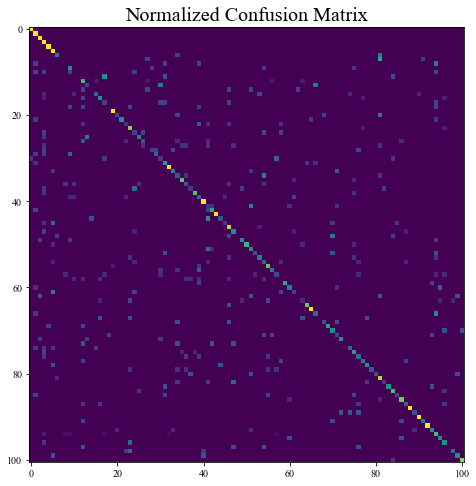

In [125]:
plt.figure(figsize=(8,8))
plt.imshow(C)
plt.title('Normalized Confusion Matrix', fontsize=20)
plt.show()

In [126]:
for j in range (len(C)):
    print('Accuracy of classification for ' + str(category_filenames[j]) + ' category is :')
    print(C[j,j]*100)      
    idx = np.where(C[j,:] != 0)[0]
    idx = np.delete(idx, np.where(idx == j))
    print('misclassified as')
    for i in range (len(idx)):
        print(str(category_filenames[idx[i]]))
        print(C[j,idx[i]] * 100)

Accuracy of classification for Faces category is :
97.72727272727273
misclassified as
Faces_easy
2.272727272727273
Accuracy of classification for Faces_easy category is :
100.0
misclassified as
Accuracy of classification for Leopards category is :
100.0
misclassified as
Accuracy of classification for Motorbikes category is :
100.0
misclassified as
Accuracy of classification for accordion category is :
100.0
misclassified as
Accuracy of classification for airplanes category is :
100.0
misclassified as
Accuracy of classification for anchor category is :
40.0
misclassified as
dragonfly
20.0
scorpion
40.0
Accuracy of classification for ant category is :
0.0
misclassified as
crayfish
20.0
scorpion
60.0
tick
20.0
Accuracy of classification for barrel category is :
0.0
misclassified as
Faces_easy
20.0
dalmatian
20.0
ewer
20.0
watch
40.0
Accuracy of classification for bass category is :
50.0
misclassified as
crocodile
16.666666666666664
kangaroo
16.666666666666664
revolver
16.666666666666664
A

#### <span style='font-family:"Times New Roman"'> <span styel=''>Timewise, the classification took more time compared to last part. If the hu moments were coded efficiently, it shouldn’t take more than couple of minutes to extract features and classify the data. The classifier reached almost 62 percent of accuracy which is acceptable for performance of linear classifier with such a large dataset.
#### <span style='font-family:"Times New Roman"'> <span styel=''>Some categories like Face_easy, leopards, motorbikes, accordion, etc. reached 100 percent accuracy level which is really good. Also, some categories like cannon, wild cat, octopus, etc. had 0 percent classification accuracy. 
#### <span style='font-family:"Times New Roman"'> <span styel=''>Some misclassifications are strange. For instance, 16.66 percent of gramophones are classified as pandas! Or, 40 percent of headphones are categorized as pandas which is strange classification. 
#### <span style='font-family:"Times New Roman"'> <span styel=''>On the other hand, some misclassifications make sense like misclassifying ants as scorpions make sense since in a zoomed version, they look like the same to some extents.
#### <span style='font-family:"Times New Roman"'> <span styel=''>Finally, there is no logical trend in misclassification of the data since some misclassifications make sense while others won’t.     


## <span style='font-family:"Times New Roman"'> <span styel=''>(g-vii) (Graduate Only) Performance on the entire CalTech101 dataset without annotations:

#### <span style='font-family:"Times New Roman"'> <span styel=''>In this part, he classification for all data in dataset without mask is considered.   

In [127]:
start_time = time.time()

my_category = sorted(glob.glob(image_directory + '\\*'))
category_filenames = []
for i in range(len(my_category)):
    category_filenames.append(my_category[i][21:])

image_directory = '101_ObjectCategories'
mask_directory = 'Annotations'

myfeature = []
mylabel = []
y_train = []
y_test = []
XX_train = []
XX_test = []

for f, category_name in enumerate(category_filenames):
    
    imagenames = sorted(glob.glob(image_directory + '\\' + category_filenames[f] +'\\*'))
     
    masknames = sorted(glob.glob(mask_directory + '\\' + category_filenames[f] +'\\*'))
    
    image_names = [v for v, w in zip(imagenames, masknames) if v[-8:-4] == w[-8:-4]]
    
    mask_names = [v for v, w in zip(masknames, imagenames) if w[-8:-4] == v[-8:-4]]
    
    mylabel.append([category_filenames[f]] * len(image_names))

    myfeature = np.zeros((62,len(image_names)))
    
    for m in range (len(image_names)):
        
        my_features = []
        
        
        arrmask = gen_mask(image_names[m],mask_names[m])
            
        arrmask = np.ones((arrmask.shape))
            
        f_color,fnames=extract_color_features(image_names[m],arrmask)
        
        f_texture , fnames = extract_texture_features(image_names[m], arrmask)
        
        my_features.extend(f_color)
        my_features.extend(f_texture)
        
        myfeature[:,m] = my_features
                                
    XX_train.append(myfeature[:,0 : np.floor(0.9 * len(image_names)).astype(int)])
    y_train.extend(mylabel[f][0 : np.floor(0.9 * len(image_names)).astype(int)])
    XX_test.append(myfeature[:,np.floor(0.9 * len(image_names)).astype(int) : len(image_names) + 1])        
    y_test.extend(mylabel[f][np.floor(0.9 * len(image_names)).astype(int) : len(image_names)+1])

elapsed_time = time.time() - start_time
    
X_train = np.concatenate(XX_train, axis=1)
X_test = np.concatenate(XX_test, axis=1)

In [128]:
print('Elapsed Time (Minutes):')
print(elapsed_time/60)

Elapsed Time (Minutes):
6.420078384876251


In [129]:
Xn_train, mx, mn = normalize_Xtrain(X_train)
Xn_test = normalize_Xtest(X_test, mx, mn)
clf = svm.SVC(kernel='linear') 
clf.fit(Xn_train.T, y_train)
y_test_hat = clf.predict(Xn_test.T)

In [130]:
C = sklearn.metrics.confusion_matrix(y_test, y_test_hat, labels = category_filenames)
print('Confusion Matrix for all dataset for classifier is: ')
print(C)

Confusion Matrix for all dataset for classifier is: 
[[39  4  0 ...  0  0  0]
 [ 4 39  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  0  3]]


In [131]:
acc = np.diag(C).sum().astype(float) / C.sum()
print('The accuracy for all dataset for classifier is: ')
print(acc)

The accuracy for all dataset for classifier is: 
0.407244785949506


In [132]:
C = C/C.sum(axis=1)[:,None]

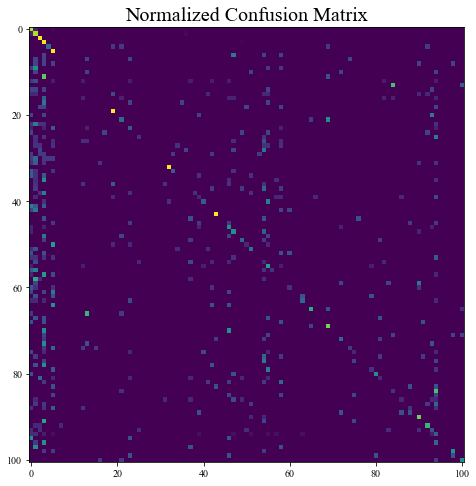

In [133]:
plt.figure(figsize=(8,8))
plt.imshow(C)
plt.title('Normalized Confusion Matrix', fontsize=20)
plt.show()

In [134]:
for j in range (len(C)):
    print('Accuracy of classification for ' + str(category_filenames[j]) + ' category is :')
    print(C[j,j]*100)      
    idx = np.where(C[j,:] != 0)[0]
    idx = np.delete(idx, np.where(idx == j))
    print('misclassified as')
    for i in range (len(idx)):
        print(str(category_filenames[idx[i]]))
        print(C[j,idx[i]] * 100)

Accuracy of classification for Faces category is :
88.63636363636364
misclassified as
Faces_easy
9.090909090909092
airplanes
2.272727272727273
Accuracy of classification for Faces_easy category is :
88.63636363636364
misclassified as
Faces
9.090909090909092
elephant
2.272727272727273
Accuracy of classification for Leopards category is :
100.0
misclassified as
Accuracy of classification for Motorbikes category is :
97.5
misclassified as
cellphone
1.25
hedgehog
1.25
Accuracy of classification for accordion category is :
33.33333333333333
misclassified as
car_side
16.666666666666664
cellphone
16.666666666666664
pagoda
16.666666666666664
trilobite
16.666666666666664
Accuracy of classification for airplanes category is :
100.0
misclassified as
Accuracy of classification for anchor category is :
0.0
misclassified as
Motorbikes
20.0
hawksbill
40.0
kangaroo
20.0
llama
20.0
Accuracy of classification for ant category is :
0.0
misclassified as
Faces_easy
20.0
Motorbikes
20.0
brain
20.0
chandelie

#### <span style='font-family:"Times New Roman"'> <span styel=''>As expected, without annotation files, the accuracy of classification is degraded significantly. The significant change in accuracy is noticeable when there are much less categories with 100 percentage accuracy. Again, misclassification seems to have no logical trend. For instance, 2.27 percent of Faces_easy category is misclassified as elephants. Or 20 percent of anchor category is misclassified as llama.   

# <span style='font-family:"Times New Roman"'> <span styel=''>(h) Summary

#### <span style='font-family:"Times New Roman"'> <span styel=''>In this project, image classification using linear Support Vector Machine is performed. 
#### <span style='font-family:"Times New Roman"'> <span styel=''>Following conclusions are achieved:
#### <span style='font-family:"Times New Roman"'> <span styel=''>The importance of proper feature extraction as well as number of features are highlighted. Since one cannot select a set of features as the most important features for all the possible images in dataset, selection of different features as well as enough number of them should be guaranteed to have a satisfactory performance.
#### <span style='font-family:"Times New Roman"'> <span styel=''>SVM is a linear classifier and is the best for two classes. When dealing with a large dataset, we should not expect a good accuracy for such a classifier. Achieving 62 percent accuracy for all images in dataset is acceptable while it falls behind compared to state of an art classifiers using Neural Networks.
#### <span style='font-family:"Times New Roman"'> <span styel=''>Incorporating object annotation with images to extract features are of significant importance. In an image, there might be plenty of other objects that are not our main goals in image classification. Also, by considering all pixels in the image, we may get features that are not related to the targeted objects (flamingo in the sea or airplane on the sky).     
#### <span style='font-family:"Times New Roman"'> <span styel=''>The SVM worked well when dealing with two categories and it reached higher accuracy which was expected. On categories like Face_easy (the reason it may be easy because it has easy tag!), it did work well when considering all possible features. In some cases, as mentioned in last section, it did misclassified objects poorly and strange like misclassifying headphones as panda.
#### <span style='font-family:"Times New Roman"'> <span styel=''>The biggest issue in image classification is selection of good classifier and having good set of features. One cannot expect a linear classifier to large amount of multiclass classify data with higher accuracy. Also, feature selection as highlighted before is important in classification performance. One should select all possible important features. However, it may not guarantee a good classification performance for different sets of images.   